In [1]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import csv
from sklearn.externals import joblib
from keras import Sequential
from keras.layers import Dense
from scipy import integrate

def capcurve(y_values, y_preds_proba):
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x': [0, rate_pos_obs, 1], 'y': [0, 1, 1]})
    xx = np.arange(num_count) / float(num_count - 1)

    y_cap = np.c_[y_values, y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    #    y_cap_df_s = y_cap_df_s.sort_values(by=[1], ascending=False).reset_index('index', drop=True)
    y_cap_df_s = y_cap_df_s.sort_values(by=[1], ascending=False).reset_index(drop=True)

    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)

    yy = np.append([0], yy[0:num_count - 1])  # add the first curve point (0,0) : for xx=0 we have yy=0

    percent = 0.5
    row_index = int(np.trunc(num_count * percent))
    #    print(row_index)
    #    print(type(yy))
    val_y1 = yy[row_index]
    val_y2 = yy[row_index + 1]
    if val_y1 == val_y2:
        val = val_y1 * 1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index + 1]
        val = val_y1 + ((val_x2 - percent) / (val_x2 - val_x1)) * (val_y2 - val_y1)

    sigma_ideal = 1 * xx[int(num_pos_obs) - 1] / 2 + (xx[num_count - 1] - xx[int(num_pos_obs)]) * 1
    sigma_model = integrate.simps(yy, xx)
    sigma_random = integrate.simps(xx, xx)

    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    # ar_label = 'ar value = %s' % ar_value

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.plot(ideal['x'], ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx, yy, color='red', label='User Model')
    # ax.scatter(xx,yy, color='red')
    ax.plot(xx, xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1,
            label=str(val * 100) + '% of positive obs at ' + str(percent * 100) + '%')

    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - a_r value =" + str(ar_value))
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()
    plt.show()
    return



# load the dataset
file= 'C:/Users/yanka/Desktop/fix income/data.mat'
#csvfile = open('C:/Users/yanka/Desktop/fix income/trainset.csv')
#reader=csv.reader(csvfile)
data = sio.loadmat(file)
print(data)
X = data['data1'] #trainset1 39786*56 matrix
Y = data['data2'] #trainset2 39786*1 matrix
#%%
import pandas as pd
Xdf=pd.DataFrame(data=X)
Xdf.fillna(Xdf.mean(),inplace=True)
X=Xdf.values
#%%

print(X.shape)
print(Y.shape)

# 绘制原始数据图谱
plt.figure()
plt.plot(range(54), np.transpose(X))
#plt.plot(np.arange(1000, 50000, 2), np.transpose(X))
plt.xlabel('User loan info')
plt.ylabel('Credit Status')
plt.title('Credit default risk')
plt.show()

# 划分训练集、验证集与测试集
k = np.random.permutation(X.shape[0])
print(k)
X_train = X[k[:35808], :]      # train set
Y_train = Y[k[:35808], :]

X_test = X[35808:, :]       # test set
Y_test = Y[35808:, :]

# uniformization
mms = preprocessing.MinMaxScaler()
X_train = mms.fit_transform(X_train)
X_test = mms.transform(X_test)       #利用训练集的标准作用于测试集，最后再外推。

Y_train = mms.fit_transform(Y_train)
Y_test = mms.transform(Y_test)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

# Build MLP
from sklearn.neural_network import MLPClassifier
nn = MLPClassifier(hidden_layer_sizes=(100,100),      # 2 hidden layers, each layer contains 100 nodes
                  activation='tanh',
                  solver='sgd',
                  alpha=0.0001,
                  batch_size='auto',
                  learning_rate='adaptive',
                  learning_rate_init=0.1,
                  power_t=0.5,
                  max_iter=1000000,
                  shuffle=True,
                  random_state=None,
                  tol=0.0001,
                  verbose=False,
                  warm_start=False,
                  momentum=0.9,
                  nesterovs_momentum=True,
                  early_stopping=False,
                  validation_fraction=0.1,
                  beta_1=0.9,
                  beta_2=0.999,
                  epsilon=1e-08,
                  n_iter_no_change=10)



# train MLP
nn.fit(X_train, Y_train.ravel())

#joblib.dump(nn, 'nnet.model')
#
 #nn=joblib.load('nnet.model')
# MLP prediction
y_sim = nn.predict(X_test)
Y_sim = mms.inverse_transform(y_sim.reshape(len(y_sim),-1))
# Y_sim = y_sim.reshape(10,-1)

Error = np.abs(Y_sim-Y_test) / Y_test
Result = np.hstack((Y_sim, Y_test, Error))
print(Result)

# review the weights
 #print(nn.coefs_[0].shape)
#
 #print(nn.loss_)
 #print(nn.n_iter_)
# print(nn.n_layers_)


def compute_correlation(x,y):
    xbar = np.mean(x)
    ybar = np.mean(y)
    ssr = 0.0
    var_x = 0.0
    var_y = 0.0
    for i in range(0,len(x)):
        diff_xbar = x[i] - xbar
        dif_ybar = y[i] - ybar
        ssr += (diff_xbar * dif_ybar)
        var_x += diff_xbar**2
        var_y += dif_ybar**2
    sst = np.sqrt(var_x * var_y)
    return ssr/sst


R = compute_correlation(Y_sim, Y_test)
print(R**2)

#%%
def print_score(Y_sim, y_test):
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    print("Test Result:\n")        
    print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, Y_sim)))
    #print("accuracy score: {0:.4f}\n".format(accuracy_score(Y_train, X_train)))
    print("Classification Report: \n {}\n".format(classification_report(y_test, Y_sim)))
    #print("Classification Report: \n {}\n".format(classification_report(Y_train, X_train)))
    print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, Y_sim)))
    #print("Confusion Matrix: \n {}\n".format(confusion_matrix(Y_train, X_train)))


print_score(np.transpose(Y_sim).tolist()[0],np.transpose( Y_test).tolist()[0])
#print_score(np.transpose(X_train).tolist()[0],np.transpose( Y_train).tolist()[0])

#model=nn.fit(X_train, Y_train.ravel())
#from sklearn.externals import joblib
#joblib.dump(model,"fixincome.pkl")

classifier=nn
classifier.fit(X_train,Y_train)
# Creating CAP Curve
y_pred_proba = classifier.predict_proba(X=X_test)
Y_test=np.ravel(Y_test)
capcurve(Y_test, y_pred_proba[:,1])

D:\Anaconda\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
Using TensorFlow backend.


{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sun Dec  1 19:11:16 2019', '__version__': '1.0', '__globals__': [], 'data1': array([[3.5000e+04, 3.5000e+04, 3.4975e+04, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [9.5000e+03, 9.5000e+03, 9.5000e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.8000e+03, 3.8000e+03, 3.8000e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [3.2500e+03, 3.2500e+03, 3.2500e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+04, 1.0000e+04, 1.0000e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [4.9000e+03, 4.9000e+03, 4.9000e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]]), 'data2': array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=uint8)}
(39786, 54)
(39786, 1)


<Figure size 640x480 with 1 Axes>

[24679 37074  3044 ...  3556  1455 32395]
(35808, 54)
(35808, 1)
(3978, 54)
(3978, 1)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:154: RuntimeWarning: divide by zero encountered in true_divide
D:\Anaconda\lib\site-packages\ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in true_divide
D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[[ 0.  0. nan]
 [ 1.  1.  0.]
 [ 0.  0. nan]
 ...
 [ 0.  0. nan]
 [ 0.  0. nan]
 [ 0.  0. nan]]
[0.84178453]
Test Result:

accuracy score: 0.9766

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.98      0.99      0.99      3295
         1.0       0.94      0.93      0.93       683

    accuracy                           0.98      3978
   macro avg       0.96      0.96      0.96      3978
weighted avg       0.98      0.98      0.98      3978


Confusion Matrix: 
 [[3252   43]
 [  50  633]]



<Figure size 1000x1000 with 1 Axes>

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


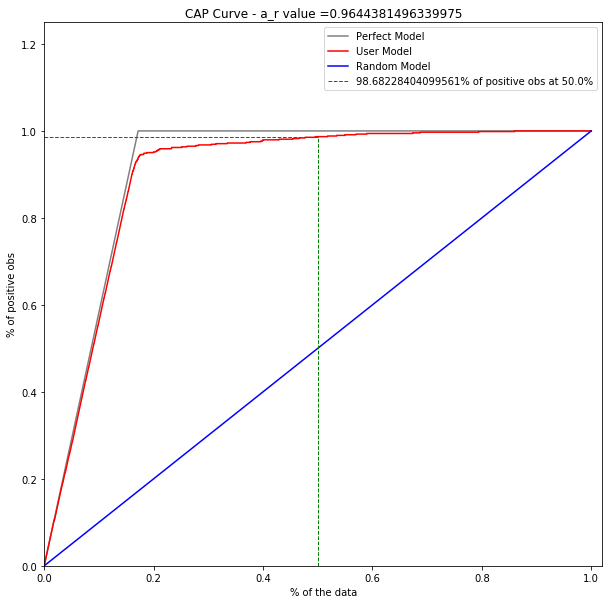

In [2]:
classifier=nn
classifier.fit(X_train,Y_train)
# Creating CAP Curve
y_pred_proba = classifier.predict_proba(X=X_test)
Y_test=np.ravel(Y_test)
capcurve(Y_test, y_pred_proba[:,1])

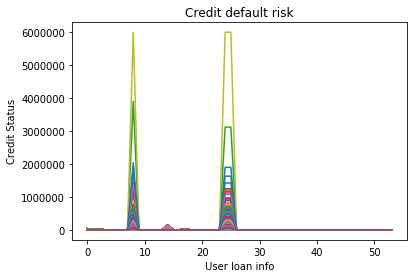

In [3]:
plt.figure()
plt.plot(range(54), np.transpose(X))
#plt.plot(np.arange(1000, 50000, 2), np.transpose(X))
plt.xlabel('User loan info')
plt.ylabel('Credit Status')
plt.title('Credit default risk')
plt.show()

In [5]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

dfTrain = pd.read_csv(r'E:\Machine Learning\COVID-19\randomtrain.csv')
dfTest = pd.read_csv(r'E:\Machine Learning\COVID-19\randomtest.csv')
dfTrain.fillna(dfTrain.mean(),inplace=True)
dfTest.fillna(dfTest.mean(),inplace=True)

#%%

X_train=dfTrain.drop(['loan_status'], axis=1, inplace=False)
y_train=dfTrain['loan_status']

X_test=dfTest.drop(['loan_status'], axis=1, inplace=False)
y_test=dfTest['loan_status']
#%%
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))   
        
    elif train==False:
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, clf.predict(X_test))))
        print("Classification Report: \n {}\n".format(classification_report(y_test, clf.predict(X_test))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, clf.predict(X_test))))    
#%%
#from sklearn.model_selection import train_test_split
#X_train, X_val, y_train, y_val = train_test_split(dfTrain.drop('loan_status',axis=1),dfTrain['loan_status'],test_size=0.15,random_state=101)
#%%
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test=sc.transform(X_test)
#%%Oversampling only the training set using Synthetic Minority Oversampling Technique
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=12)
x_train_r, y_train_r = sm.fit_sample(X_train, y_train)




In [6]:
#%%
#logistic Regression
#Using logistic Regression model to classify states
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C = 0.005,random_state=10)

log_reg.fit(x_train_r, y_train_r)

print_score(log_reg, x_train_r, y_train_r, X_test, y_test, train=False)

Test Result:

accuracy score: 0.7428

Classification Report: 
               precision    recall  f1-score   support

 Charged Off       0.39      0.84      0.53       683
  Fully Paid       0.96      0.72      0.82      3295

    accuracy                           0.74      3978
   macro avg       0.67      0.78      0.68      3978
weighted avg       0.86      0.74      0.77      3978


Confusion Matrix: 
 [[ 571  112]
 [ 911 2384]]



In [7]:
#%%
#RandomForest
#Using RandomForest model to classify states
#from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
clf_rf = RandomForestClassifier(n_estimators=40, random_state=21,min_samples_split=4)
clf_rf.fit(x_train_r, y_train_r)
print_score(clf_rf, x_train_r, y_train_r, X_test, y_test, train=True)

Train Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

 Charged Off       1.00      1.00      1.00      3295
  Fully Paid       1.00      1.00      1.00      3295

    accuracy                           1.00      6590
   macro avg       1.00      1.00      1.00      6590
weighted avg       1.00      1.00      1.00      6590


Confusion Matrix: 
 [[3295    0]
 [   0 3295]]

Average Accuracy: 	 0.9341
Accuracy SD: 		 0.0315
Test Result:

accuracy score: 1.0000

Classification Report: 
               precision    recall  f1-score   support

 Charged Off       1.00      1.00      1.00       683
  Fully Paid       1.00      1.00      1.00      3295

    accuracy                           1.00      3978
   macro avg       1.00      1.00      1.00      3978
weighted avg       1.00      1.00      1.00      3978


Confusion Matrix: 
 [[ 683    0]
 [   0 3295]]

